In [1]:
# Directory 
import os
os.chdir("/home/jovyan/work/GP")
print(os.getcwd())

/home/jovyan/work/GP


In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import math
import pyproj

In [3]:
# Read & Check data
Accident_London_vru = pd.read_csv("df_per_coll_London_vru_s1_correct.csv")
print(
    f"There are {Accident_London_vru.shape[0]} rows and {Accident_London_vru.shape[1]} columns."
)#df size
print(Accident_London_vru["police_force"].value_counts()) # London [1,48]
print(Accident_London_vru["casualty_type"].value_counts()) # VRU
print(Accident_London_vru.columns) # mixed types of variables in 'accident_index_x' and 'accident_reference_x'

There are 75963 rows and 23 columns.
police_force
1     75161
48      802
Name: count, dtype: int64
casualty_type
1     24594
0     22292
3     20348
5      3592
4      3006
2      1655
23      295
97       92
22       89
Name: count, dtype: int64
Index(['accident_index', 'accident_year_x', 'accident_reference_x',
       'longitude', 'latitude', 'police_force', 'accident_severity', 'date',
       'day_of_week', 'local_authority_district', 'road_type', 'speed_limit',
       'light_conditions', 'weather_conditions', 'road_surface_conditions',
       'lsoa_of_accident_location', 'casualty_class', 'sex_of_casualty',
       'casualty_severity', 'pedestrian_location', 'casualty_type',
       'casualty_distance_banding', 'time'],
      dtype='object')


/tmp/ipykernel_32064/4039250167.py:2: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  Accident_London_vru = pd.read_csv("df_per_coll_London_vru_s1_correct.csv")


In [4]:
# Transform projection of point data (in meters)
# WGS84 (EPSG:4326) 地理坐标系 -> WGS 84 / UTM zone 38S (EPSG:6538)
wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 坐标系（经纬度）
utm_38s = pyproj.CRS('EPSG:6538')  # WGS 84 / UTM zone 38S 投影坐标系

# 创建转换器
transformer = pyproj.Transformer.from_crs(wgs84, utm_38s, always_xy=True)

# 执行坐标转换
Accident_London_vru['easting'], Accident_London_vru['northing'] = transformer.transform(Accident_London_vru['longitude'].values, Accident_London_vru['latitude'].values)

# 将转换后的 DataFrame 重命名为 Accident_London_vru_proj
Accident_London_vru_proj = Accident_London_vru.copy()

# 查看转换后的投影坐标（以米为单位）
print(Accident_London_vru_proj.head(3))

  accident_index  accident_year_x accident_reference_x  longitude   latitude  \
0  2019010155191             2019             10155191  -0.124193  51.526795   
1  2019010155192             2019             10155192  -0.191044  51.546387   
2  2019010155196             2019             10155196  -0.099071  51.367605   

   police_force  accident_severity        date  day_of_week  \
0             1                  3  01/01/2019            3   
1             1                  2  01/01/2019            3   
2             1                  3  01/01/2019            3   

   local_authority_district  ...  lsoa_of_accident_location  casualty_class  \
0                         2  ...                  E01000943               2   
1                         2  ...                  E01000973               3   
2                        20  ...                  E01001043               3   

   sex_of_casualty  casualty_severity  pedestrian_location casualty_type  \
0                2               

In [5]:
# Define a function to calculate KDE credit to @derekhe99
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs):#输入x,y坐标，宽带，网格的分辨率，kernel方法

    # create grid of sample locations
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]
#转换网格为坐标
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T #将两个一维数组堆叠成一个二维数组，并通过 .T 转置，使得每一行都代表一个坐标点（[y, x]）
    xy_train  = np.vstack([y, x]).T #将原始的 x 和 y 数据堆叠并转置，得到每个数据点的 (x, y) 坐标。

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs) #初始化一个核密度估计模型
    kde_skl.fit(xy_train) #将数据传递给模型以进行训练

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample)) #将对数密度值转换为实际的密度值 z
    return xx, yy, np.reshape(z, xx.shape) #function返回网格坐标和密度值z

In [6]:
# easting & northing data 2019
Accident_London_vru_proj_2019 = Accident_London_vru_proj[Accident_London_vru_proj['accident_year_x'] == 2019] 
x = Accident_London_vru_proj_2019['easting'].values
y = Accident_London_vru_proj_2019['northing'].values

In [7]:
# Calculate KED
xx,yy,densities_2019 = kde2D(x=x,y=y,bandwidth=200)

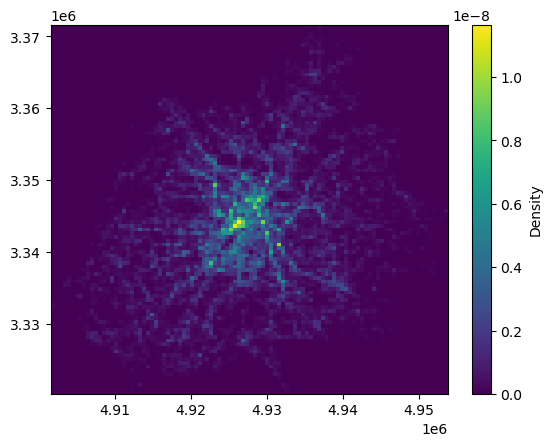

In [13]:
# Visualize 
# 绘制KDE结果
mesh = plt.pcolormesh(xx, yy, densities_2019, shading='auto', cmap='viridis')
plt.colorbar(mesh, label='Density')
plt.show()

In [15]:
# easting & northing data 2022
Accident_London_vru_proj_2022 = Accident_London_vru_proj[Accident_London_vru_proj['accident_year_x'] == 2022] 
x = Accident_London_vru_proj_2022['easting'].values
y = Accident_London_vru_proj_2022['northing'].values

In [18]:
# Calculate KED 2022
xx,yy,densities_2022 = kde2D(x=x,y=y,bandwidth=200)

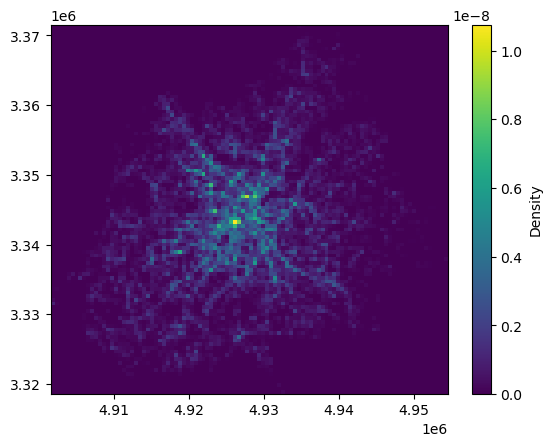

In [19]:
# Visualize 2022
# 绘制KDE结果
mesh = plt.pcolormesh(xx, yy, densities_2022, shading='auto', cmap='viridis')
plt.colorbar(mesh, label='Density')
plt.show()

In [28]:
# easting & northing data 2023
Accident_London_vru_proj_2023 = Accident_London_vru_proj[Accident_London_vru_proj['accident_year_x'] == 2023] 
x = Accident_London_vru_proj_2023['easting'].values
y = Accident_London_vru_proj_2023['northing'].values

In [10]:
# Calculate KED 2023
xx,yy,densities_2023 = kde2D(x=x,y=y,bandwidth=200)

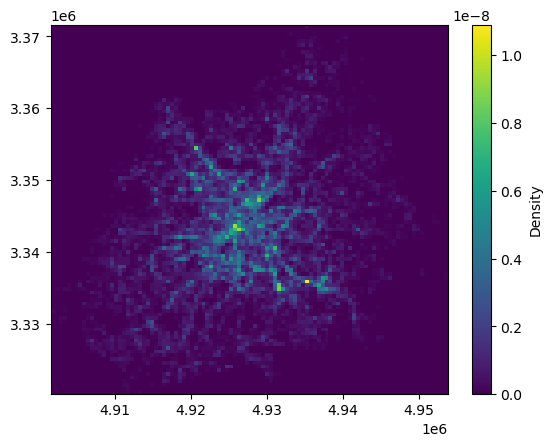

In [12]:
# Visualize 2023
# 绘制KDE结果
mesh = plt.pcolormesh(xx, yy, densities_2023, shading='auto', cmap='viridis')
plt.colorbar(mesh, label='Density')
plt.show()

In [20]:
# Define a function for kde_weighting 
def kde2D_with_weights(x, y, weights, bandwidth, xbins=100j, ybins=100j, **kwargs):
    """
    Perform 2D Kernel Density Estimation with weights.
    
    Parameters:
    - x, y: Coordinates for the data points (e.g., easting and northing).
    - weights: The weights for each data point (e.g., severity or another metric).
    - bandwidth: Bandwidth parameter for the Kernel Density Estimation.
    - xbins, ybins: Resolution of the grid for plotting (default: 100j for each axis).
    - kwargs: Additional parameters to pass to the KernelDensity model.
    
    Returns:
    - xx, yy: The grid of coordinates for the KDE plot.
    - z: The computed density values (with weights).
    """
    
    # Create grid of sample locations
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]
    
    # Convert grid points to a 2D array
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    
    # Prepare the input data as a 2D array of (x, y) coordinates
    xy_train = np.vstack([y, x]).T
    
    # Initialize the Kernel Density Estimator with the given bandwidth
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    
    # Fit the KDE model with the data and corresponding weights
    kde_skl.fit(xy_train, sample_weight=weights)
    
    # Use score_samples to calculate the log-likelihood of each sample point
    z = np.exp(kde_skl.score_samples(xy_sample))  # Convert log-likelihood to actual density
    
    return xx, yy, np.reshape(z, xx.shape)  # Return grid coordinates and the density values


In [30]:
# Create weighting based on severity 2023
# 定义严重程度到权重的映射
severity_to_weight = {1: 3, 2: 2, 3: 1}  # 1 -> Fatal -> 3, 2 -> Serious -> 2, 3 -> Slight -> 1

# 创建一个新的权重列
Accident_London_vru_proj_2023['weights'] = Accident_London_vru_proj_2023['casualty_severity'].map(severity_to_weight)

# 查看数据
print(Accident_London_vru_proj_2023.head(3))

      accident_index  accident_year_x accident_reference_x  longitude  \
60182  2023010419171             2023             10419171  -0.202878   
60183  2023010419191             2023             10419191  -0.263972   
60184  2023010419192             2023             10419192  -0.168976   

        latitude  police_force  accident_severity        date  day_of_week  \
60182  51.418974             1                  3  01/01/2023            1   
60183  51.597575             1                  3  01/01/2023            1   
60184  51.477324             1                  3  01/01/2023            1   

       local_authority_district  ...  casualty_class  sex_of_casualty  \
60182                        -1  ...               3                2   
60183                        -1  ...               1                1   
60184                        -1  ...               1                1   

       casualty_severity  pedestrian_location  casualty_type  \
60182                  3             

/tmp/ipykernel_32064/1041956408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Accident_London_vru_proj_2023['weights'] = Accident_London_vru_proj_2023['casualty_severity'].map(severity_to_weight)


In [31]:
# Calculate weighted KED 2023
w = Accident_London_vru_proj_2023['weights'].values

In [32]:
xx,yy,densities_w_2023 = kde2D_with_weights(x=x,y=y,weights = w, bandwidth=200)

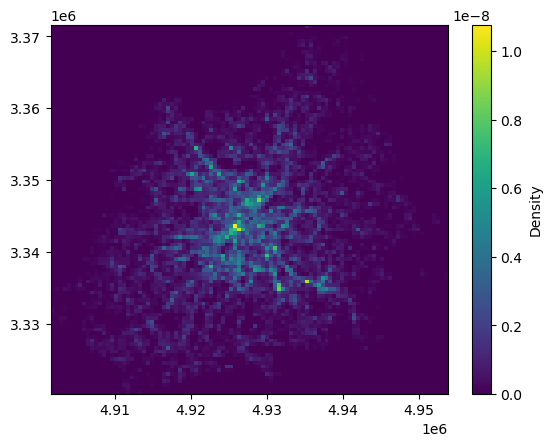

In [35]:
# Visualize 2023
# 绘制KDE结果
mesh = plt.pcolormesh(xx, yy,densities_w_2023)
plt.colorbar(mesh, label='Density')
plt.show()

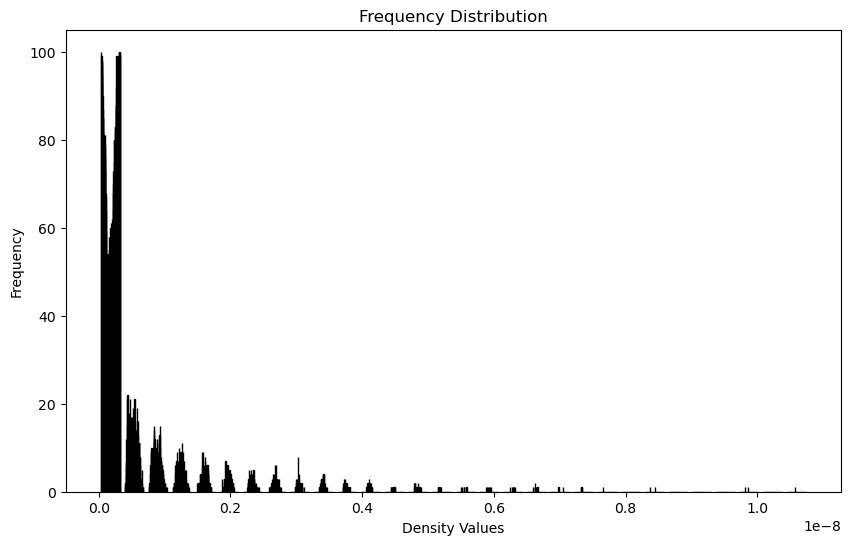

In [47]:
import matplotlib.pyplot as plt

# 假设 densities_w_2023 是您的数据
plt.figure(figsize=(10, 6))
plt.hist(densities_w_2023, bins=30, edgecolor='black', linewidth=1)

# 添加标题和标签
plt.title("Frequency Distribution")
plt.xlabel("Density Values")
plt.ylabel("Frequency")

# 显示图形
plt.show()

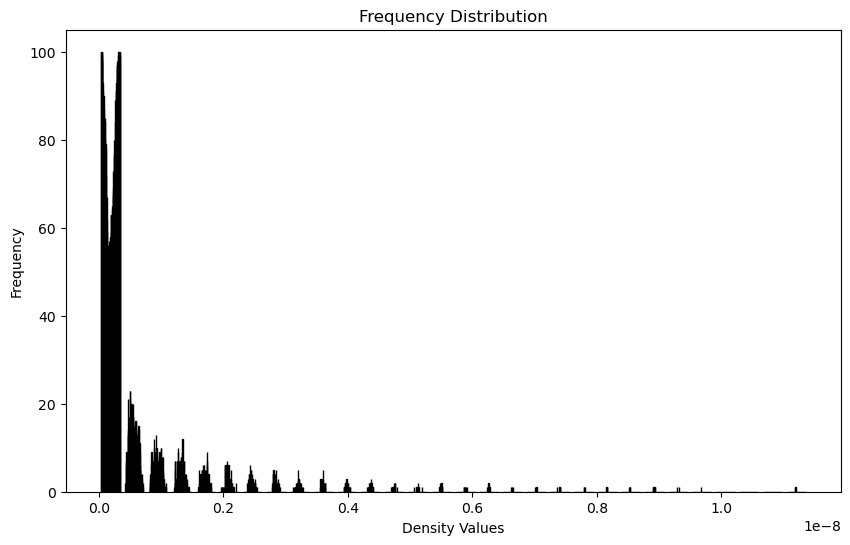

In [48]:
import matplotlib.pyplot as plt

# 假设 densities_w_2019 是您的数据
plt.figure(figsize=(10, 6))
plt.hist(densities_w_2019, bins=30, edgecolor='black', linewidth=1)

# 添加标题和标签
plt.title("Frequency Distribution")
plt.xlabel("Density Values")
plt.ylabel("Frequency")

# 显示图形
plt.show()

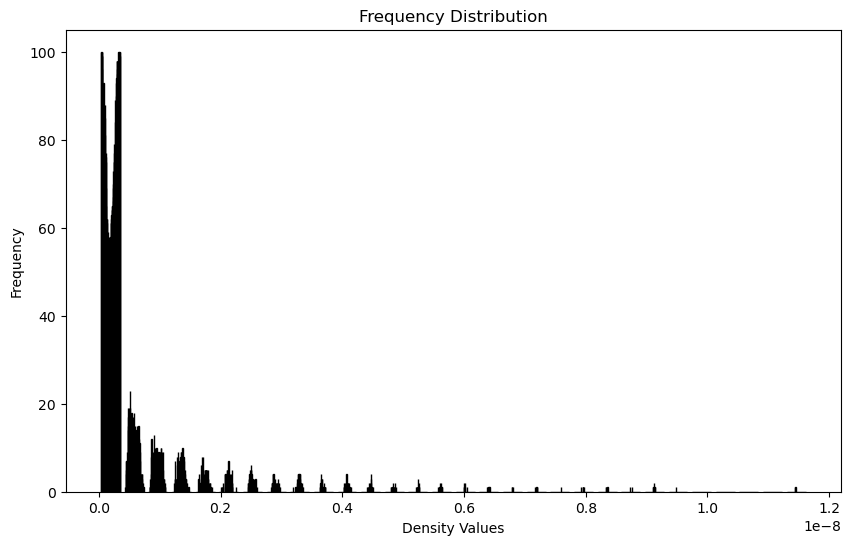

In [49]:
import matplotlib.pyplot as plt

# 假设 densities_w_2019 是您的数据
plt.figure(figsize=(10, 6))
plt.hist(densities_2019, bins=30, edgecolor='black', linewidth=1)

# 添加标题和标签
plt.title("Frequency Distribution")
plt.xlabel("Density Values")
plt.ylabel("Frequency")

# 显示图形
plt.show()

In [ ]:
'''方法2 基于KDE分布的百分位数
通过分析KDE的密度分布，您可以选择密度值处于某个百分位数以上的区域作为热点。例如，选择所有密度值在 前 10% 或 前 25% 之间的区域作为热点。
方法3：基于标准差的阈值
您可以计算所有区域的 平均密度 和 标准差，然后选择所有密度值超过平均密度加上某个倍数标准差的区域作为热点。例如，选择密度值大于 mean + 2 * std 的区域作为热点。'''

In [ ]:
'''
# Find the optimal bandwidth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KernelDensity
import numpy as np
data = Accident_London_vru_proj[['easting', 'northing']].values
bandwidths = 10 ** np.linspace(-4, -2, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(data)
grid.best_params_
'''

In [36]:
# Create weighting based on severity 2019
# 定义严重程度到权重的映射
severity_to_weight = {1: 3, 2: 2, 3: 1}  # 1 -> Fatal -> 3, 2 -> Serious -> 2, 3 -> Slight -> 1

# 创建一个新的权重列
Accident_London_vru_proj_2019['weights'] = Accident_London_vru_proj_2019['casualty_severity'].map(severity_to_weight)

# 查看数据
print(Accident_London_vru_proj_2019.head(3))

  accident_index  accident_year_x accident_reference_x  longitude   latitude  \
0  2019010155191             2019             10155191  -0.124193  51.526795   
1  2019010155192             2019             10155192  -0.191044  51.546387   
2  2019010155196             2019             10155196  -0.099071  51.367605   

   police_force  accident_severity        date  day_of_week  \
0             1                  3  01/01/2019            3   
1             1                  2  01/01/2019            3   
2             1                  3  01/01/2019            3   

   local_authority_district  ...  casualty_class  sex_of_casualty  \
0                         2  ...               2                2   
1                         2  ...               3                1   
2                        20  ...               3                1   

   casualty_severity  pedestrian_location  casualty_type  \
0                  3                    0              1   
1                  2         

/tmp/ipykernel_32064/3418643277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Accident_London_vru_proj_2019['weights'] = Accident_London_vru_proj_2019['casualty_severity'].map(severity_to_weight)


In [39]:
# Calculate weighted KED 2019
w = Accident_London_vru_proj_2019['weights'].values

In [41]:
# easting & northing data 2019
Accident_London_vru_proj_2019 = Accident_London_vru_proj[Accident_London_vru_proj['accident_year_x'] == 2019] 
x = Accident_London_vru_proj_2019['easting'].values
y = Accident_London_vru_proj_2019['northing'].values

In [42]:
xx,yy,densities_w_2019 = kde2D_with_weights(x=x,y=y,weights = w, bandwidth=200)

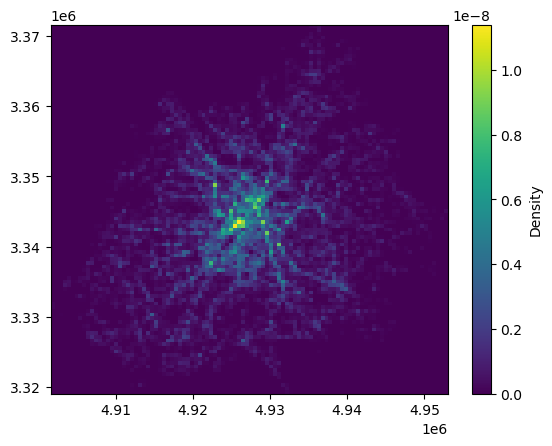

In [43]:
# Visualize 2019
# 绘制KDE结果
mesh = plt.pcolormesh(xx, yy,densities_w_2019)
plt.colorbar(mesh, label='Density')
plt.show()